In [ ]:
# default_exp bayesian
%load_ext autoreload
%autoreload 2

from nbdev import *
from utilities.ipynb_docgen import *

# Bayesian Blocks

> Partition a light curve with the Bayesian Block algorithm

The functions implemented here are:

- `get_bb_partition` to perform a BB partition. It requires a "fitness" function to perform an evaluation of the 
likelihoods for a set of sequential cells. There are two such, using the number of counts, and the Kerr likelihood. See the [Bayesian Block reference](https://arxiv.org/pdf/1207.5578.pdf).

 - `CountFitness`
 - `LikelihoodFitness`, the default
 

- `bb_overplot` which overplots fits to the partitioned blocks on the original light curve.


In [ ]:
#export
import os
import numpy as np
import pandas as pd
from astropy.stats.bayesian_blocks import FitnessFunc

from wtlike.config import *
from wtlike.lightcurve import get_lightcurve, fit_cells, flux_plot
from wtlike.cells import get_cells, partition_cells


In [ ]:
#export
class CountFitness(FitnessFunc):
    """
    Adapted version of a astropy.stats.bayesian_blocks.FitnessFunc
    Considerably modified to give the `fitness function` access to the cell data.
    
    Implements the Event model using exposure instead of time.

    """

    def __init__(self, lc, p0=0.05,):
        """
        - lc  -- a LightCurve data table, with  exposure (e) and counts (n),
            as well as a representation of the likelihood for each cell
        - p0 --
        """
        self.p0=p0
        self.df= df= lc
        N = self.N = len(df)
        # Invoke empirical function from Scargle 2012
        self.ncp_prior = self.p0_prior(N)

        #actual times for bin edges
        t = df.t.values
        dt = df.tw.values/2
        self.mjd = np.concatenate([t-dt, [t[-1]+dt[-1]] ] ) # put one at the end
        self.name = self.__class__.__name__
        self.setup()

    def setup(self):
        df = self.df

        # counts per cell
        self.nn = df.n.values
        assert min(self.nn)>0, 'Attempt to Include a cell with no contents'

        # edges and block_length use exposure as "time"
        e = df.e.values
        self.edges = np.concatenate([[0], np.cumsum(e)])
        self.block_length = self.edges[-1] - self.edges

    def __str__(self):
        
        return f'{self.name}: {self.N} cells, spanning {self.block_length[0]:.1f} days, prior={self.ncp_prior:.1f}'
        
    def __call__(self, R):
        """ The fitness function needed for BB algorithm
        For cells 0..R return array of length R+1 of the maximum log likelihoods for combined cells
        0..R, 1..R, ... R
        """
        # exposures and corresponding counts
        w_k = self.block_length[:R + 1] - self.block_length[R + 1]
        N_k = np.cumsum(self.nn[:R + 1][::-1])[::-1]

        # Solving eq. 26 from Scargle 2012 for maximum $\lambda$ gives
        return N_k * (np.log(N_k) - np.log(w_k))

    def fit(self):
        """Fit the Bayesian Blocks model given the specified fitness function.
        Refactored version using code from bayesian_blocks.FitnesFunc.fit
        Returns
        -------
        edges : ndarray
            array containing the (M+1) edges, in MJD units, defining the M optimal bins
        """
        # This is the basic Scargle algoritm, copied almost verbatum
        # ---------------------------------------------------------------

        # arrays to store the best configuration
        N = self.N
        best = np.zeros(N, dtype=float)
        last = np.zeros(N, dtype=int)

        # ----------------------------------------------------------------
        # Start with first data cell; add one cell at each iteration
        # ----------------------------------------------------------------
        for R in range(N):

            # evaluate fitness function
            fit_vec = self(R)

            A_R = fit_vec - self.ncp_prior
            A_R[1:] += best[:R]

            i_max = np.argmax(A_R)
            last[R] = i_max
            best[R] = A_R[i_max]

        # ----------------------------------------------------------------
        # Now find changepoints by iteratively peeling off the last block
        # ----------------------------------------------------------------
        change_points = np.zeros(N, dtype=int)
        i_cp = N
        ind = N
        while True:
            i_cp -= 1
            change_points[i_cp] = ind
            if ind == 0:
                break
            ind = last[ind - 1]
        change_points = change_points[i_cp:]

        return self.mjd[change_points]

#export
class LikelihoodFitness(CountFitness):
    """ Fitness function that uses the full likelihood
    """
    
    def __init__(self, lc,  p0=0.05, npt=50):
        self.npt = npt
        super().__init__(lc, p0)
        
    def setup(self):
        df = self.df
        N = self.N
        
        def liketable(prep):
            return prep.create_table(self.npt)
        
        self.tables = df.fit.apply(liketable).values

    def __str__(self):
        return f'{self.__class__.__name__}: {self.N} cells,  prior={self.ncp_prior:.1f}'

    def __call__(self, R):
        
        a, y  = self.tables[R]
        x = np.linspace(*a)
        y = np.zeros(self.npt)
        rv = np.empty(R+1)
        for i in range(R, -1, -1): 
            a, yi = self.tables[i]
            xi = np.linspace(*a)
            y += np.interp(x, xi, yi, left=-np.inf, right=-np.inf)
            amax = np.argmax(y)
            rv[i] =y[amax]
        return rv    

In [ ]:
#collapse_hide
lcs ={}
def data_setup(lcs = lcs, mjd_query='54750<t<54855', names=['Geminga','3C 279']):
    """
    ### Generate data sets for an AGN and a pulsar
    {printout}
    
    Choose the time interval, {mjd_query} ({days} days) to bracket a modest flare of the AGN.
     
    <table>
    <tr> <td>Pulsar</td><td>AGN</td></tr>
    <tr>
    <td>{fig1}</td> <td>{fig2}</td>
    </tr>
    </table>
    """
    
    from wtlike.config import Config,  PointSource
    from wtlike.lightcurve import get_lightcurve, flux_plot
    config = Config()
    figs=[]
    plt.rc('font', size=20)
    with capture_print('printout') as printout:
        for i,name in enumerate(names):
            lcfull = get_lightcurve(config,  PointSource(name))
            lc = lcs[name] = lcfull.query(mjd_query) if mjd_query else lcfull
            fig= flux_plot(config,lc, fignum=i, title=name)
            figs.append(figure(fig, width=300))
    fig1, fig2 = figs
    mjd_query = mjd_query.replace('<', '&lt;')
    days = len(lc)
    return locals()

if Config().valid:
    nbdoc(data_setup, lcs, mjd_query='54750<t<54855', )

### Generate data sets for an AGN and a pulsar
<details  class="nbdoc-description" >  <summary> printout </summary>  <div style="margin-left: 5%"><pre>Light curve for Geminga: Restoring from cache with key "lightfcurve_Geminga"<br>Light curve for 3C 279: Restoring from cache with key "lightfcurve_3C 279"<br></pre></div> </details>

Choose the time interval, 54750&lt;t&lt;54855 (105 days) to bracket a modest flare of the AGN.
 
<table>
<tr> <td>Pulsar</td><td>AGN</td></tr>
<tr>
<td><div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 2">  <a href="images/data_setup_fig_02.png" title="images/data_setup_fig_02.png">    <img src="images/data_setup_fig_02.png" alt="Figure 2 at images/data_setup_fig_02.png" width=300>   </a> </figure>
</div>
</td> <td><div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 3">  <a href="images/data_setup_fig_03.png" title="images/data_setup_fig_03.png">    <img src="images/data_setup_fig_03.png" alt="Figure 3 at images/data_setup_fig_03.png" width=300>   </a> </figure>
</div>
</td>
</tr>
</table>


In [ ]:
#collapse_hide
def doc_countfitness( fitness, light_curve_dict, source_name):
    """
    #### {class_name} test with source {source_name}
         
    Create object: `bbfitter = {class_name}(lc)`
    
    Object description:   {bbfitter}
    
    Then `bbfitter({n})` returns the values
        {values}
   
    Finally, the partition algorithm, 'bbfitter.fit()' returns {cffit}
    
    """
    
    lc = light_curve_dict[source_name]
    bbfitter = fitness(lc)
    class_name = bbfitter.name
    n = 10
    values  = np.array(bbfitter(n)).round(1)    
    cffit = bbfitter.fit()
    
    return locals()

In [ ]:
#hide

if Config().valid:
    nbdoc(doc_countfitness, CountFitness, light_curve_dict = lcs, source_name='Geminga')
    nbdoc(doc_countfitness, CountFitness, light_curve_dict = lcs, source_name='3C 279')
     

#### CountFitness test with source Geminga
     
Create object: `bbfitter = CountFitness(lc)`

Object description:   CountFitness: 105 cells, spanning 131.0 days, prior=4.9

Then `bbfitter(10)` returns the values
    [14517.  13066.1 11631.2 10159.8  9106.2  7633.9  6573.   5173.6  3959.6
  2746.6  1451.2]

Finally, the partition algorithm, 'bbfitter.fit()' returns [54750. 54788. 54855.]


#### CountFitness test with source 3C 279
     
Create object: `bbfitter = CountFitness(lc)`

Object description:   CountFitness: 105 cells, spanning 138.0 days, prior=4.9

Then `bbfitter(10)` returns the values
    [1657.1 1431.1 1267.9 1145.3  919.4  811.2  648.   510.2  378.7  266.3
  148.2]

Finally, the partition algorithm, 'bbfitter.fit()' returns [54750. 54754. 54785. 54790. 54807. 54827. 54855.]


In [ ]:
#export
def get_bb_partition(config, lc, fitness_class=LikelihoodFitness, p0=0.05, key=None):    

    """Perform Bayesian Block partition of the cells found in a light curve
    
    - lc : input light curve
    - fitness_class 
    
    return edges for partition
    """
    assert issubclass(fitness_class,CountFitness), 'fitness_class wrong'
    assert 'fit' in lc.columns, 'Expect the dataframe ho have the Poisson representation'


    def doit():
        fitness = fitness_class(lc, p0=p0)
        # Now run the astropy Bayesian Blocks code using my version of the 'event' model
        return fitness.fit() 
        
    key = f'BB_edges_' if key is '' else key
    
    edges = config.cache(key, doit,  description=key if config.verbose>0 else '')
    
    if config.verbose>0:
        print(f'Partitioned {len(lc)} cells into {len(edges)-1} blocks, using {fitness_class.__name__} ' )
    return edges

In [ ]:
show_doc(get_bb_partition, title_level=2)

<h2 id="get_bb_partition" class="doc_header"><code>get_bb_partition</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h2>

> <code>get_bb_partition</code>(**`config`**, **`lc`**, **`fitness_class`**=*`LikelihoodFitness`*, **`p0`**=*`0.05`*, **`key`**=*`None`*)

Perform Bayesian Block partition of the cells found in a light curve

- lc : input light curve
- fitness_class 

return edges for partition

In [ ]:
#collapse_hide
config = Config()

def test_bb(lcs, name, fitness):
    """
    ### BB partition for {name} using {fitness.__name__}
    
    {lc_fig}
    """
    lc = lcs[name]
    edges = get_bb_partition(config, lc, fitness, key=None) 
    lc_fig = flux_plot(config, lc, title=f'{name} partition with {fitness.__name__}')
    lc_fig.width=400
    ax = lc_fig.axes[0]
    edges = np.concatenate([edges, [edges[-1]] ])
    for  i,t in enumerate(edges[::2]):
        if 2*i+1==len(edges): break
        t2 = edges[2*i+1]
        ax.axvspan(t, t2, color='lightcyan')
    for t in edges:
        ax.axvline(t, ls=':', color='cyan')
    return locals()

if config.valid:
    nbdoc(test_bb, lcs, '3C 279', CountFitness, name='count')
    nbdoc(test_bb, lcs, '3C 279', LikelihoodFitness, name='like')
#     nbdoc(test_bb, lcs, 'Geminga', CountFitness)
#     nbdoc(test_bb, lcs, 'Geminga', LikelihoodFitness)

Partitioned 105 cells into 6 blocks, using CountFitness 


### BB partition for 3C 279 using CountFitness

<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 1">  <a href="images/count_fig_01.png" title="images/count_fig_01.png">    <img src="images/count_fig_01.png" alt="Figure 1 at images/count_fig_01.png" width=400>   </a> </figure>
</div>



Partitioned 105 cells into 7 blocks, using LikelihoodFitness 


### BB partition for 3C 279 using LikelihoodFitness

<div class="nbdoc_image">
<figure style="margin-left: 5%" title="Figure 1">  <a href="images/like_fig_01.png" title="images/like_fig_01.png">    <img src="images/like_fig_01.png" alt="Figure 1 at images/like_fig_01.png" width=400>   </a> </figure>
</div>



In [ ]:
#export
def bb_overplot(config, lc, bb_fit, ax=None, **kwargs):
    """Plot light curve: cell fits with BB overplot
    
    """
    fig, ax = plt.subplots(1,1, figsize=(12,4)) if not ax else (ax.figure, ax)
    flux_plot(config, lc, ax=ax, colors=(('lightblue', 'sandybrown', 'blue')),**kwargs)
    flux_plot(config, bb_fit, ax=ax, step=True, **kwargs)

In [ ]:
show_doc(bb_overplot,title_level=2)

<h2 id="bb_overplot" class="doc_header"><code>bb_overplot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h2>

> <code>bb_overplot</code>(**`config`**, **`lc`**, **`bb_fit`**, **`ax`**=*`None`*, **\*\*`kwargs`**)

Plot light curve: cell fits with BB overplot
    
    

### Fit blocks and overplot

The following code shows how to refit, and demonstrates the overplot function.

Partitioned 105 cells into 7 blocks, using LikelihoodFitness 
Cell data for 3C 279: Restoring from cache with key "cells_3C 279"
Loaded 7 / 7 cells with exposure > 0.3 for fitting


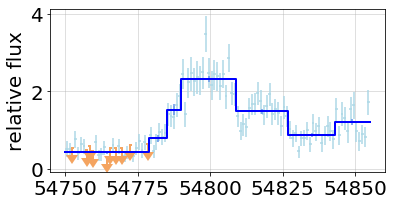

In [ ]:
if config.valid:
    name = '3C 279'
    lc = lcs[name]
    source = PointSource(name)

    # generate the edges
    edges  = get_bb_partition(config, lc,  key=None) 
    
    # to refit, need the cells again
    cells = get_cells(config, source)
    bb_cells = partition_cells(config, cells, edges);
    bb_fit = fit_cells(config, bb_cells, )
    
    # now use bb_overplot to see the result
    fig, ax = plt.subplots(figsize=(6,3))
    bb_overplot(config, lc, bb_fit, ax=ax);

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01-data_man.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_gti.ipynb.
Converted 03_exposure.ipynb.
Converted 04_photon_data.ipynb.
Converted 05_weights.ipynb.
Converted 06_poisson.ipynb.
Converted 07_cells.ipynb.
Converted 08_loglike.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10_simulation.ipynb.
Converted 14_bayesian.ipynb.
Converted index.ipynb.
Sat Feb  6 06:34:31 PST 2021
